In [ ]:
import keras
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
def getData(labelpath, picpath):
	labels = pd.read_csv(labelpath, sep=",", header=None)
	labels.columns = ["lat", "lon", "pic"]
	outputs = labels[["lat", "lon"]]
	pic_files = labels["pic"]

	inputs = []

	for file in pic_files:
		# load the image, swap color channels, and resize it to be a fixed
		# 224x224 pixels while ignoring aspect ratio just for now
		image = cv2.imread(picpath+file)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (224, 224))
		# update the input lists
		inputs.append(image)

	# convert the inputs and outputs to NumPy arrays
	inputs = np.array(inputs)
	outputs = np.array(outputs)

	return [inputs, outputs]


In [6]:
# read data for training
[data, labels] = getData("/content/gdrive/My Drive/Lab5-Material/fdh/label.txt","/content/gdrive/My Drive/Lab5-Material/fdh/images/")

In [7]:
data.shape

(2387, 224, 224, 3)

In [38]:
# normalize labels
meanlatlon = np.mean(labels,axis=0)
stdlatlon = np.std(labels,axis=0)
print(meanlatlon)
print(stdlatlon)

[45.43601452 12.33532211]
[0.00509069 0.0086982 ]


In [42]:
labels = (labels-meanlatlon)/stdlatlon
print(labels)

[[-0.82965646 -0.74671901]
 [ 0.52045554 -0.25086915]
 [-0.21461199 -0.51609652]
 ...
 [ 0.99367244 -0.59622806]
 [ 0.48490043 -0.01898202]
 [-0.45603315 -0.14475521]]


In [43]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [10]:
trainX.shape

(1909, 224, 224, 3)

In [11]:
trainY.shape

(1909, 2)

In [21]:
# construct modified resnet
baseModel = keras.applications.ResNet101(weights="imagenet", include_top=False,	input_tensor=Input(shape=(224, 224, 3)))

In [13]:
baseModel.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [22]:
# get the output before the classifier
base_output = baseModel.output

In [23]:
# change classifier to regressor output dimension is 2
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(2, activation='relu')(base_output)

model = Model(inputs=baseModel.input, outputs=base_output)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [24]:
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [46]:
#opt = Adam(lr=1e-4)
#model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
print("[INFO] training head...")
model.fit(trainX, trainY, epochs=50, batch_size=128, shuffle=True)


[INFO] training head...
Epoch 1/50
15/15 [==============================] - 8s 563ms/step - loss: 1.3819
Epoch 2/50
15/15 [==============================] - 9s 576ms/step - loss: 1.3280
Epoch 3/50
15/15 [==============================] - 9s 590ms/step - loss: 1.2853
Epoch 4/50
15/15 [==============================] - 9s 588ms/step - loss: 1.2523
Epoch 5/50
15/15 [==============================] - 9s 576ms/step - loss: 1.2233
Epoch 6/50
15/15 [==============================] - 8s 565ms/step - loss: 1.2006
Epoch 7/50
15/15 [==============================] - 8s 561ms/step - loss: 1.1818
Epoch 8/50
15/15 [==============================] - 8s 556ms/step - loss: 1.1658
Epoch 9/50
15/15 [==============================] - 8s 558ms/step - loss: 1.1521
Epoch 10/50
15/15 [==============================] - 8s 561ms/step - loss: 1.1408
Epoch 11/50
15/15 [==============================] - 8s 566ms/step - loss: 1.1308
Epoch 12/50
15/15 [==============================] - 9s 570ms/step - loss: 1.1219
E

(224, 224, 3)


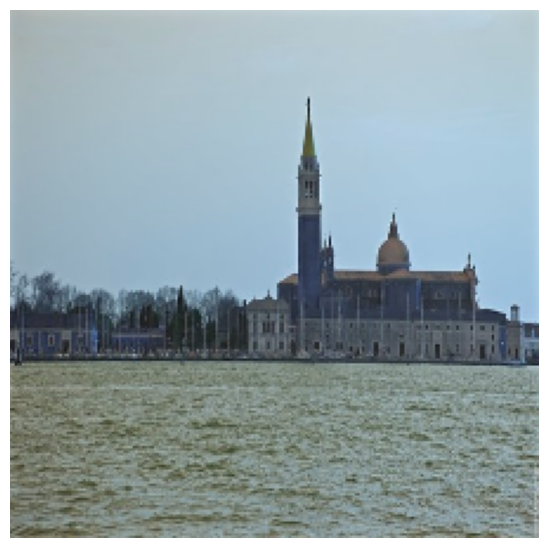

In [52]:
import matplotlib.pyplot as plt

image = cv2.imread("/content/gdrive/My Drive/Lab5-Material/fdh/test1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test = cv2.resize(image, (224, 224))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), dpi=100, sharex=True, sharey=True)
ax.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
ax.axis('off')

print(test.shape)

In [53]:
predictY = model.predict(test.reshape(1,224,224,3))

In [54]:
predictY = predictY*stdlatlon+meanlatlon
print(predictY)

[[45.43601452 12.33532211]]
